### 1. Import and read

#### 1.1. Import libraries

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy import stats
from scipy.ndimage import gaussian_filter1d

#### 1.2. Load CSV and read top 10

In [4]:
# Load csv with top ten emojis

df = pd.read_csv("emoji10_tableau.csv")
df.head()

,date,sender,emoji,unicode
0,2021-12-09,Mariam,:heart_suit:,U+2665
1,2022-06-20,Rio,:smiling_face:,U+263A
2,2024-03-08,Rio,:smiling_face:,U+263A
3,2024-03-10,Mariam,:smiling_face:,U+263A
4,2024-03-10,Mariam,💛,U+1F49B


In [5]:
df["emoji"].unique()

array([':heart_suit:', ':smiling_face:', '💛', '😌', ':melting_face:', '😂',
       '🥺', '🥰', '😭', '🥲'], dtype=object)

In [6]:
# Optional: show all rows
#pd.set_option("display.max_rows", None)

# Optional: show all columns
pd.set_option("display.max_columns", None)

In [7]:
df["emoji"].value_counts()

emoji
😂                 4829
:heart_suit:      3996
🥺                 1894
🥰                 1416
💛                 1139
😭                  958
😌                  622
:smiling_face:     608
🥲                  556
:melting_face:     501
Name: count, dtype: int64

### 1.3. Optional: set timeframe for the visualization

In [8]:
# Example: remove data prior to 2024

#df = df[df["date"] >= "2024-01-01"]

# (Optional) reset index after filtering
#emoji_counts = emoji_counts.reset_index(drop=True)

#df["date"].min()

### <b> SKIP THIS IF YOUR NOTEBOOK CAN READ EMOJIS <b>  ###

If your notebook does not display emojis, here you can add pngs that will override the labels

#### Step 1: Create a dictionary that maps the unicodes to their emoji

In [8]:
key = df.set_index('unicode')['emoji'].to_dict()
key

{'U+2665': ':heart_suit:',
 'U+263A': ':smiling_face:',
 'U+1F49B': '💛',
 'U+1F60C': '😌',
 'U+1FAE0': ':melting_face:',
 'U+1F602': '😂',
 'U+1F97A': '🥺',
 'U+1F970': '🥰',
 'U+1F62D': '😭',
 'U+1F972': '🥲'}

Download the emojis [here](https://emoji.aranja.com/) or [here](https://emojigraph.org/apple/).
<br>Make sure to save them in a file that lives in the same folder as your project.
<br>Rename the files with the correct UTF. Save as .PNG.

#### Step 2: Write emoji paths

In [10]:
emoji_images = {
    "U+1F602": "emojis/U+1F602.png",
    "U+2665": "emojis/U+2665.png",
    "U+1F97A": "emojis/U+1F97A.png",
    "U+1F970": "emojis/U+1F970.png",
    "U+1F49B": "emojis/U+1F49B.png"
}

### 2. Prepare the dataframe for visualization

#### 2.1. Group the emoji counts by date

In [12]:
emoji_counts_by_date = df.groupby(['date', 'unicode']).size().reset_index(name='count')
emoji_counts_by_date

,date,unicode,count
0,2021-12-09,U+2665,1
1,2022-06-20,U+263A,1
2,2024-03-08,U+263A,1
3,2024-03-10,U+1F49B,1
4,2024-03-10,U+263A,1
...,...,...,...
2723,2025-10-20,U+1F602,7
2724,2025-10-20,U+1F970,3
2725,2025-10-20,U+1F972,1
2726,2025-10-20,U+1F97A,2


#### 2.2. Pivot to a wide dataframe

In [13]:
df_wide = emoji_counts_by_date.pivot(index='date', columns='unicode', values='count').fillna(0)
df_wide.head()

unicode,U+1F49B,U+1F602,U+1F60C,U+1F62D,U+1F970,U+1F972,U+1F97A,U+1FAE0,U+263A,U+2665
date,,,,,,,,,,
2021-12-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-06-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### 2.3. Convert the index to datetime

In [15]:
df_wide.index = pd.to_datetime(df_wide.index)

# Optional: remove time part and keep only date (still as Timestamp objects)
df_wide.index = df_wide.index.normalize()

# Check
df_wide.index.dtype

dtype('<M8[ns]')

### 3. Draw Streamgraph

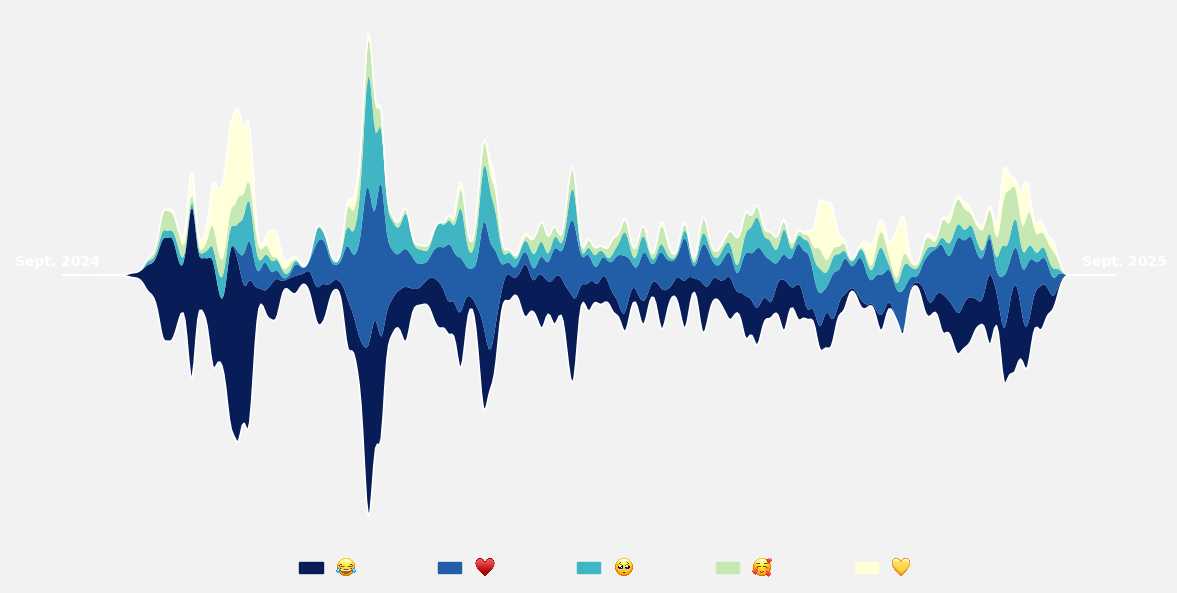

In [16]:
# --- Parameters ---
sd = 2                  # Gaussian smoothing
pad = 30                # Extra zero padding at start and end
fade_len = 25           # How long to fade to zero
top_n = 5               # Number of top emojis to plot
bg_color = "#f2f2f2"    # Background color
palette = plt.cm.YlGnBu(np.linspace(1, 0, top_n))

# --- Select top emojis ---
emoji_totals = df_wide.sum(axis=0)
top_emojis = emoji_totals.sort_values(ascending=False).head(top_n).index
df_top = df_wide[top_emojis]

# --- Prepare grid ---
orig_len = len(df_top)
grid = np.arange(orig_len + 2 * pad)  # Extend for padding

# --- Prepare fade window ---
fade_window = np.ones(orig_len + 2 * pad)
fade_window[:fade_len + pad] = np.linspace(0, 1, fade_len + pad)
fade_window[-fade_len - pad:] = np.linspace(1, 0, fade_len + pad)

# --- Pad, smooth, and fade each series ---
values_smoothed = []
for emoji in top_emojis:
    y = df_top[emoji].values
    y_padded = np.concatenate([np.zeros(pad), y, np.zeros(pad)])
    y_smooth = gaussian_filter1d(y_padded, sigma=sd)
    y_fade = y_smooth * fade_window
    values_smoothed.append(y_fade)

# --- Plot symmetric stacked streamgraph ---
fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(grid, values_smoothed, colors=palette, baseline='sym', labels=top_emojis)

# --- Add white contour lines (top and bottom) ---
total_line = np.sum(values_smoothed, axis=0)
ax.plot(grid, total_line / 2, color='white', lw=1.2)
ax.plot(grid, -total_line / 2, color='white', lw=1.2)

# --- Add date labels at start and end ---
start_offset = -3   # Move label left/right in data units
end_offset = 5
y_offset = 1.5      # Vertical offset above top contour
ax.text(grid[0] + start_offset, total_line[0]/2 + y_offset, "Sept. 2024",
        ha='center', va='bottom', color='white', fontsize=10, fontweight='bold')
ax.text(grid[-1] + end_offset, total_line[-1]/2 + y_offset, "Sept. 2025",
        ha='center', va='bottom', color='white', fontsize=10, fontweight='bold')

# --- Manual emoji legend at bottom ---
y_pos = -0.05
x_step = 0.12
patch_size = 0.02
legend_width = (len(top_emojis) - 1) * x_step
x_start = 0.5 - legend_width / 2

for i, (emoji, color) in enumerate(zip(top_emojis, palette)):
    x_pos = x_start + i * x_step

    # Draw color patch
    ax.add_patch(plt.Rectangle(
        (x_pos - patch_size / 2, y_pos - patch_size / 2),
        patch_size, patch_size,
        transform=ax.transAxes,
        color=color,
        clip_on=False
    ))

    # Draw emoji image or fallback text
    if emoji in emoji_images:
        img = mpimg.imread(emoji_images[emoji])
        imagebox = OffsetImage(img, zoom=0.09)
        ab = AnnotationBbox(
            imagebox,
            (x_pos + 0.03, y_pos),
            xycoords='axes fraction',
            frameon=False
        )
        ax.add_artist(ab)
    else:
        ax.text(x_pos + 0.04, y_pos, emoji, transform=ax.transAxes,
                va='center', ha='left')

# --- Styling ---
ax.set_xticks(np.arange(0, len(df_top), step=30))
ax.set_xticklabels(df_top.index[::30], rotation=45, ha='right')
ax.axis("off")
ax.set_facecolor(bg_color)
fig.patch.set_facecolor(bg_color)
ax.grid(False)
plt.tight_layout()
plt.show()

# Optional: Save graph

#plt.savefig('Emoji_Streamgraph.png')